####  Demand and Solar Generation Forecasting Notebook


**Objective**

This notebook develops and evaluates machine learning models (Random Forest and XGBoost) for forecasting load demand and solar generation using a time series dataset (gen_data_testv2.parquet). The dataset includes hourly data with features like load_demand, solar_power, weather variables, and derived features (e.g., lags, rolling statistics). Key tasks include:
- Data preprocessing and feature engineering
- Exploratory data analysis (EDA) with visualizations
- Model training with hyperparameter tuning and time series cross-validation
- Model evaluation (MAE, RMSE, R²) and comparison
- SHAP analysis for interpretability
- Future forecasting for the next 7 days

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
import shap
import warnings

# Configure settings
warnings.filterwarnings('ignore')
plt.style.use('seaborn')
%matplotlib inline
print("xxx")

xxx


### 2. Utility Functions

Description

We define reusable functions for repetitive tasks to streamline the notebook:
- `engineer_features`: Creates time-based, lag, rolling, and interaction features.
- `split_data`: Splits data chronologically into train, validation, and test sets.
- `train_model`: Trains a model with hyperparameter tuning.
- `evaluate_and_plot`: Evaluates a model and generates forecast plots.
- `plot_comparison`: Compares multiple models' forecasts.

In [3]:
def engineer_features(df, target, lags=24):
    """
    Engineer time-based, lag, rolling, and interaction features.
    
    Parameters:
    - df: DataFrame with datetime index and target column
    - target: Column name (e.g., 'load_demand', 'solar_power')
    - lags: Number of lag features to create
    
    Returns:
    - DataFrame with new features
    """
    df = df.copy()
    # Time-based features
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    df['month'] = df.index.month
    
    # Lag features
    for lag in range(1, lags + 1):
        df[f'{target}_lag{lag}'] = df[target].shift(lag)
    
    # Rolling statistics
    df[f'{target}_roll_mean'] = df[target].rolling(window=24).mean()
    df[f'{target}_roll_std'] = df[target].rolling(window=24).std()
    
    # Interaction feature (for demand only)
    if target == 'load_demand':
        df['hour_demand'] = df['hour'] * df[f'{target}_lag1']
    
    return df.dropna()

def split_data(df, train_ratio=0.7, val_ratio=0.15):
    """
    Split data chronologically into train, validation, and test sets.
    
    Parameters:
    - df: DataFrame to split
    - train_ratio, val_ratio: Proportions for train and validation sets
    
    Returns:
    - train_df, val_df, test_df: Split DataFrames
    """
    N = len(df)
    train_size = int(train_ratio * N)
    val_size = int(val_ratio * N)
    train_df = df.iloc[:train_size]
    val_df = df.iloc[train_size:train_size + val_size]
    test_df = df.iloc[train_size + val_size:]
    return train_df, val_df, test_df

def train_model(model, param_grid, X_train, y_train, cv):
    """
    Train a model with hyperparameter tuning.
    
    Parameters:
    - model: Scikit-learn model (e.g., RandomForestRegressor)
    - param_grid: Hyperparameter grid for GridSearchCV
    - X_train, y_train: Training features and target
    - cv: Cross-validation strategy
    
    Returns:
    - Trained GridSearchCV object
    """
    grid_search = GridSearchCV(model, param_grid, cv=cv, scoring='neg_mean_absolute_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    print(f"Best Params: {grid_search.best_params_}")
    return grid_search

def evaluate_and_plot(y_true, y_pred, index, title, filename):
    """
    Evaluate a model and plot actual vs. predicted values.
    
    Parameters:
    - y_true: Actual values
    - y_pred: Predicted values
    - index: Datetime index for plotting
    - title: Plot title
    - filename: File to save plot
    
    Returns:
    - Dictionary with MAE, RMSE, R2
    """
    metrics = {
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'R2': r2_score(y_true, y_pred)
    }
    print(f"{title} Metrics: {metrics}")
    
    plt.figure(figsize=(14, 6))
    plt.plot(index, y_true, label='Actual')
    plt.plot(index, y_pred, label='Predicted')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.savefig(filename)
    plt.show()
    return metrics



def rolling_forecast(model, features, data, steps):
    """
    Perform rolling forecast with dynamically updated features.
    
    Parameters:
    - model: Trained model (e.g., XGBoost)
    - features: List of feature names
    - data: DataFrame with initial features (at least 24 rows for context)
    - steps: Number of forecast steps
    
    Returns:
    - List of forecasted values
    """
    forecasts = []
    # Ensure we start with at least 24 hours of historical data for context
    if len(data) < 24:
        raise ValueError("Initial data must contain at least 24 rows for lag and rolling features.")
    
    current_data = data.copy()
    target = next((feat.split('_lag')[0] for feat in features if '_lag' in feat), None)
    if target is None:
        raise ValueError("No lag feature found in features list.")
    
    for step in range(steps):
        # Use the most recent row for prediction
        X_future = current_data[features].iloc[-1].values.reshape(1, -1)
        pred = model.predict(X_future)[0]
        forecasts.append(pred)
        
        # Create new row for the next timestep
        new_time = current_data.index[-1] + pd.Timedelta(hours=1)
        new_row = pd.DataFrame(index=[new_time], columns=current_data.columns)
        
        # Update time-based features
        new_row['hour'] = new_time.hour
        new_row['day_of_week'] = new_time.dayofweek
        new_row['month'] = new_time.month
        
        # Update lag features using the last 24 values
        last_24 = current_data[target].tail(24).tolist() + [pred]
        for lag in range(1, 25):
            new_row[f'{target}_lag{lag}'] = last_24[-lag]
        
        # Update rolling statistics using the last 24 values (including the new prediction)
        rolling_window = last_24[-24:]  # Last 24 values including the prediction
        new_row[f'{target}_roll_mean'] = np.mean(rolling_window)
        new_row[f'{target}_roll_std'] = np.std(rolling_window)
        
        # Update interaction feature (for demand only)
        if target == 'load_demand':
            new_row['hour_demand'] = new_row['hour'] * pred
        
        # Update weather features (already set in future_df with variability)
        new_row['weather_temperature'] = current_data['weather_temperature'].iloc[-1]
        new_row['weather_humidity'] = current_data['weather_humidity'].iloc[-1]
        new_row['weather_wind_speed'] = current_data['weather_wind_speed'].iloc[-1]
        
        # Append the new row to current_data and keep only the last 24 rows
        current_data = pd.concat([current_data, new_row])
        current_data = current_data.tail(24)
    
    return forecasts

In [4]:
def plot_comparison(y_true, predictions, index, title, filename, labels):
    """
    Plot actual vs. multiple model predictions.
    
    Parameters:
    - y_true: Actual values
    - predictions: List of predicted values
    - index: Datetime index
    - title: Plot title
    - filename: File to save plot
    - labels: List of model names
    """
    plt.figure(figsize=(14, 6))
    plt.plot(index, y_true, label='Actual')
    for pred, label in zip(predictions, labels):
        plt.plot(index, pred, label=label)
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.savefig(filename)
    plt.show()

### 3. Data Loading and Preprocessing

**Description**

We load the dataset from gen_data_testv2.parquet, filter out faulty entries, and preprocess it. The dataset includes load_demand, solar_power, weather variables, and other features (e.g., hour_sin, hour_cos, day_of_year). We rename columns and set the datetime index if needed.
- Input: Parquet file with raw data
- Process: Load data, rename columns, filter faults, forward-fill missing values
- Output: Cleaned DataFrame with datetime index

In [5]:
# Load dataset
dataset_path = '/kaggle/input/predict/gen_data_testv2.parquet'
print(f"Loading dataset from {dataset_path}")
df = pd.read_parquet(dataset_path)

# Rename datetime column if needed
if 'Unnamed: 0' in df.columns:
    df = df.rename(columns={'Unnamed: 0': 'datetime'})
    df['datetime'] = pd.to_datetime(df['datetime'])
    df.set_index('datetime', inplace=True)

# Filter out faulty entries
df = df[df['fault_occurred'] == False]

# Handle missing values
df = df.fillna(method='ffill')

# Verify data
print("Dataset Info:")
print(df.info())
print("\nSample Data:")
print(df.head())

Loading dataset from /kaggle/input/predict/gen_data_testv2.parquet
Dataset Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15890 entries, 2023-01-01 00:00:00 to 2024-12-30 23:00:00
Data columns (total 42 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   weather_hour           15890 non-null  int32  
 1   weather_day_of_year    15890 non-null  int32  
 2   weather_is_weekend     15890 non-null  bool   
 3   hour                   15890 non-null  int32  
 4   day_of_year            15890 non-null  int32  
 5   is_weekend             15890 non-null  bool   
 6   hour_sin               15890 non-null  float64
 7   hour_cos               15890 non-null  float64
 8   day_sin                15890 non-null  float64
 9   day_cos                15890 non-null  float64
 10  weather_season         15890 non-null  object 
 11  season                 15890 non-null  object 
 12  weather_temperature    15890 non-null  flo

### 4. Feature Engineering

**Description**

We engineer features for `load_demand` and `solar_power` using the `engineer_features` function. Features include:





- `Time-based`: hour, day_of_week, month
- `Lags`: 1-24 hours for both targets
- Rolling stats: 24-hour mean and std
- Interaction: hour_demand (hour × load_demand_lag1) for demand

In [6]:
# Engineer features for load_demand
df = engineer_features(df, 'load_demand', lags=24)

# Engineer features for solar_power
df = engineer_features(df, 'solar_power', lags=24)

# Verify new features
print("Data with Engineered Features:")
print(df[['load_demand', 'load_demand_lag1', 'load_demand_roll_mean', 'solar_power', 'solar_power_lag1', 'solar_power_roll_mean']].head())

Data with Engineered Features:
                     load_demand  load_demand_lag1  load_demand_roll_mean  \
2023-01-03 00:00:00   561.737450        590.628518            1494.438395   
2023-01-03 01:00:00   590.774355        561.737450            1494.232740   
2023-01-03 02:00:00   674.669963        590.774355            1493.984953   
2023-01-03 03:00:00   808.347297        674.669963            1493.745005   
2023-01-03 04:00:00   983.306068        808.347297            1493.452098   

                     solar_power  solar_power_lag1  solar_power_roll_mean  
2023-01-03 00:00:00          0.0               0.0             214.837923  
2023-01-03 01:00:00          0.0               0.0             214.837923  
2023-01-03 02:00:00          0.0               0.0             214.837923  
2023-01-03 03:00:00          0.0               0.0             214.837923  
2023-01-03 04:00:00          0.0               0.0             214.837923  


### 5. Data Splitting

Description

We split the data chronologically into train (70%), validation (15%), and test (15%) sets using the split_data function to preserve time series order.

In [7]:
# Split data
train_df, val_df, test_df = split_data(df, train_ratio=0.7, val_ratio=0.15)

print(f"Train shape: {train_df.shape}")
print(f"Validation shape: {val_df.shape}")
print(f"Test shape: {test_df.shape}")

Train shape: (11089, 97)
Validation shape: (2376, 97)
Test shape: (2377, 97)


### 6. Exploratory Data Analysis (EDA)

Description

We visualize trends, seasonality, and autocorrelation to understand the data.

- **Time series PLot**

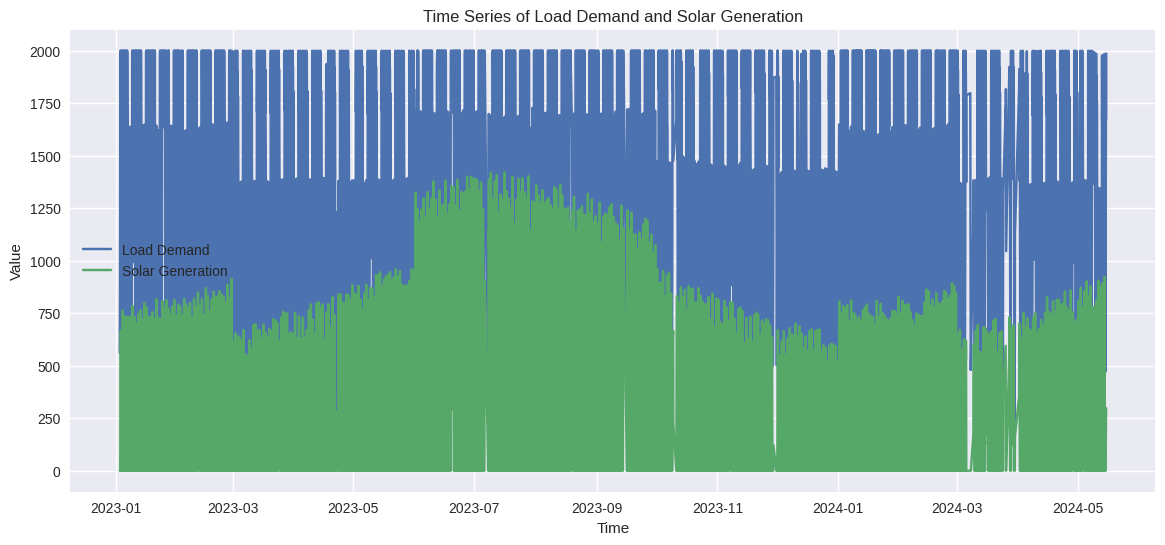

In [8]:
# Plot time series
plt.figure(figsize=(14, 6))
plt.plot(train_df.index, train_df['load_demand'], label='Load Demand')
plt.plot(train_df.index, train_df['solar_power'], label='Solar Generation')
plt.title('Time Series of Load Demand and Solar Generation')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.savefig('time_series.png')
plt.show()

- **Seasonal Decomposition**

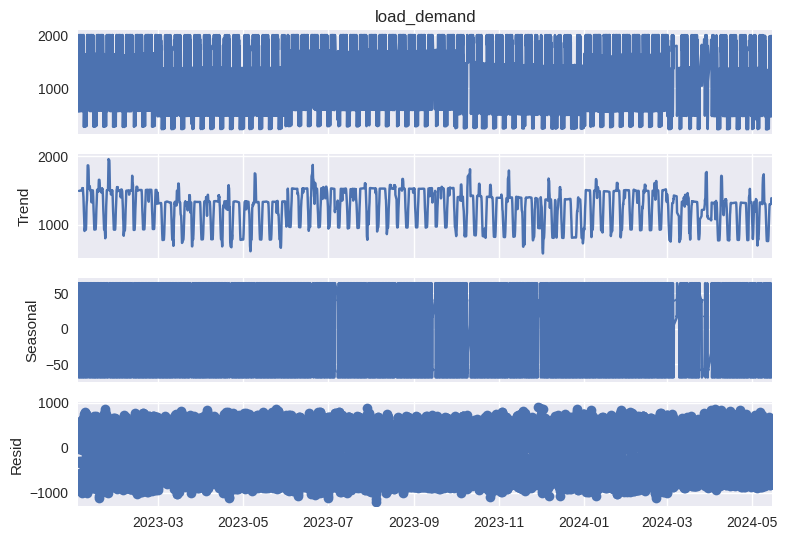

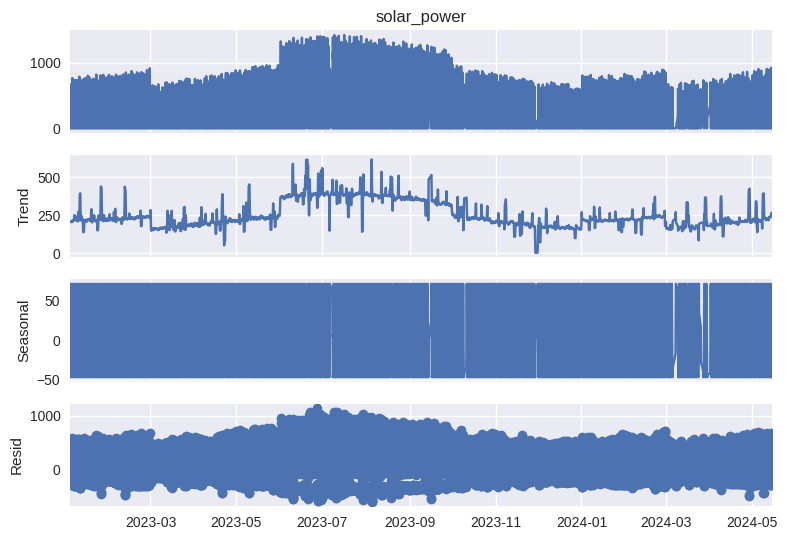

In [9]:
# Decompose load demand
decomp_demand = seasonal_decompose(train_df['load_demand'], model='additive', period=24)
decomp_demand.plot()
plt.savefig('decomp_demand.png')
plt.show()

# Decompose solar generation
decomp_solar = seasonal_decompose(train_df['solar_power'], model='additive', period=24)
decomp_solar.plot()
plt.savefig('decomp_solar.png')
plt.show()

- **Autocorrelation Plot** 

<Figure size 1400x400 with 0 Axes>

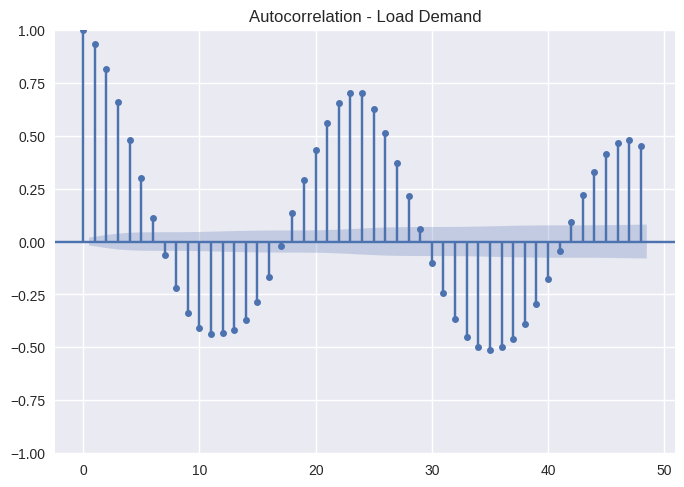

<Figure size 1400x400 with 0 Axes>

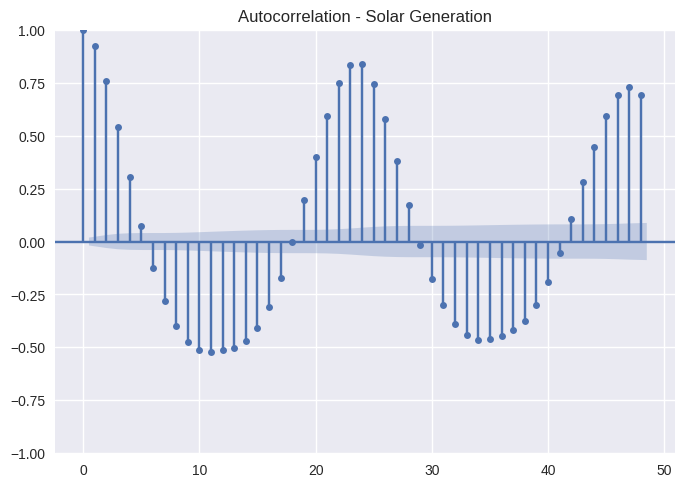

In [10]:
# Plot autocorrelation
plt.figure(figsize=(14, 4))
plot_acf(train_df['load_demand'], lags=48)
plt.title('Autocorrelation - Load Demand')
plt.savefig('acf_demand.png')
plt.show()

plt.figure(figsize=(14, 4))
plot_acf(train_df['solar_power'], lags=48)
plt.title('Autocorrelation - Solar Generation')
plt.savefig('acf_solar.png')
plt.show()

### 7. Demand Forecasting

Description

We train and evaluate Random Forest and XGBoost for load_demand forecasting using predefined features and the utility functions.

In [11]:
# Define features for demand
demand_features = [
    'hour', 'day_of_week', 'month', 'weather_temperature', 'weather_humidity', 'weather_wind_speed',
    'load_demand_roll_mean', 'load_demand_roll_std', 'hour_demand'
] + [f'load_demand_lag{i}' for i in range(1, 25)]

# Prepare training and validation data
X_train_demand = train_df[demand_features]
y_train_demand = train_df['load_demand']
X_val_demand = val_df[demand_features]
y_val_demand = val_df['load_demand']

1. **Random Forest**

Best Params: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
Random Forest - Demand Forecast Metrics: {'MAE': 14.908412242377635, 'RMSE': 56.33027714361873, 'R2': 0.9912162671681468}


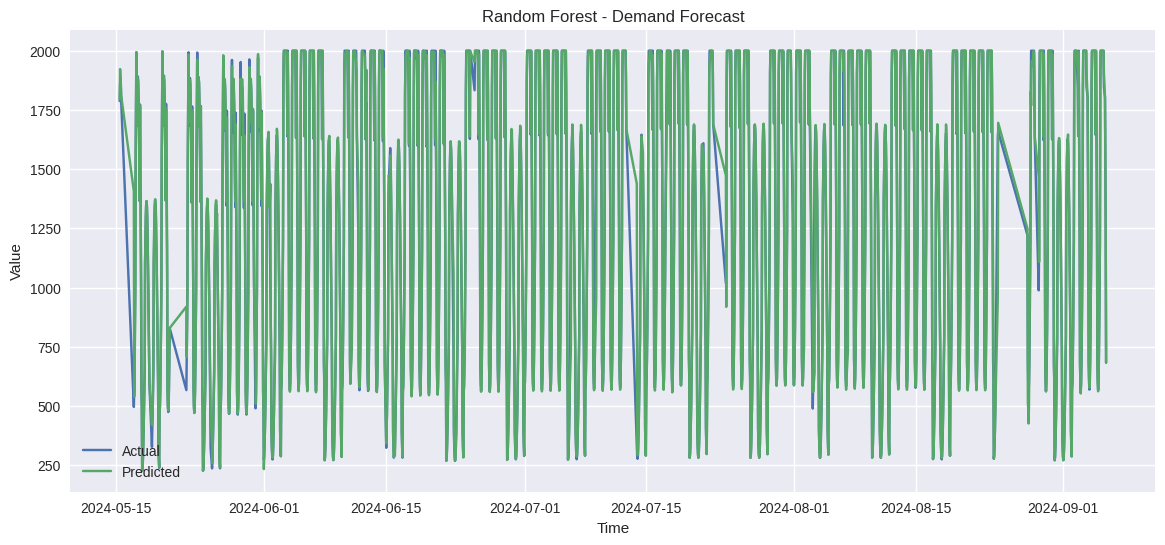

In [12]:
# Define hyperparameter grid
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5]
}

# Train RF
tscv = TimeSeriesSplit(n_splits=5)
rf_demand = train_model(RandomForestRegressor(random_state=42), rf_param_grid, 
                        X_train_demand, y_train_demand, tscv)

# Evaluate and plot
rf_demand_pred = rf_demand.predict(X_val_demand)
rf_demand_metrics = evaluate_and_plot(y_val_demand, rf_demand_pred, val_df.index, 
                                     'Random Forest - Demand Forecast', 'rf_demand.png')

2. **XGBoost**

Best Params: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200}
XGBoost - Demand Forecast Metrics: {'MAE': 18.352320727753632, 'RMSE': 50.61947710636661, 'R2': 0.9929069887112102}


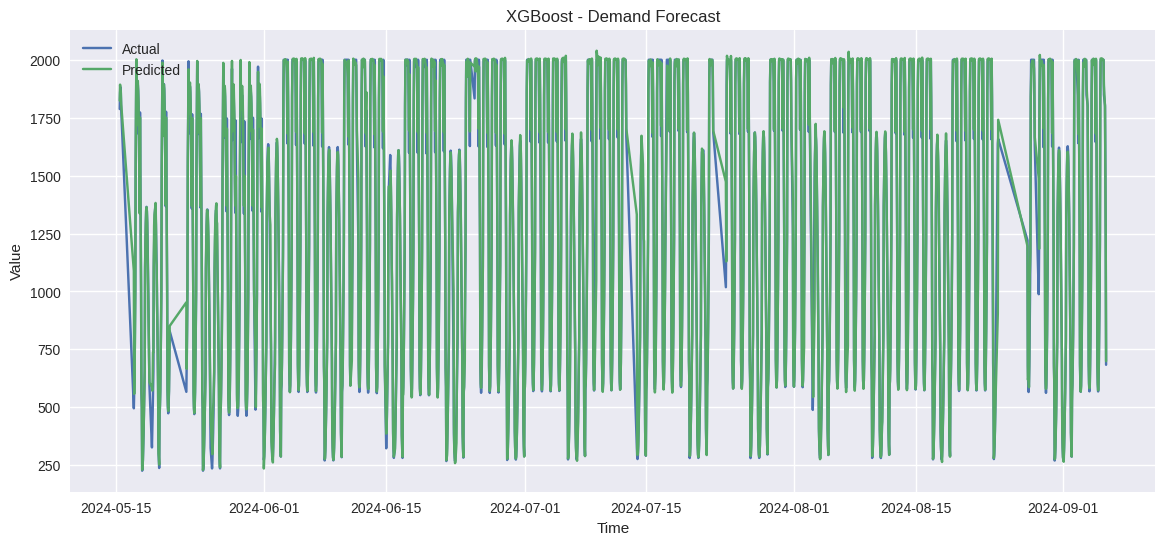

In [13]:
# Define hyperparameter grid
xgb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6],
    'learning_rate': [0.01, 0.1]
}

# Train XGB
xgb_demand = train_model(XGBRegressor(random_state=42), xgb_param_grid, 
                         X_train_demand, y_train_demand, tscv)

# Evaluate and plot
xgb_demand_pred = xgb_demand.predict(X_val_demand)
xgb_demand_metrics = evaluate_and_plot(y_val_demand, xgb_demand_pred, val_df.index, 
                                      'XGBoost - Demand Forecast', 'xgb_demand.png')

**Comparision**

Demand Metrics Comparison:
                     MAE       RMSE        R2
Random Forest  14.908412  56.330277  0.991216
XGBoost        18.352321  50.619477  0.992907


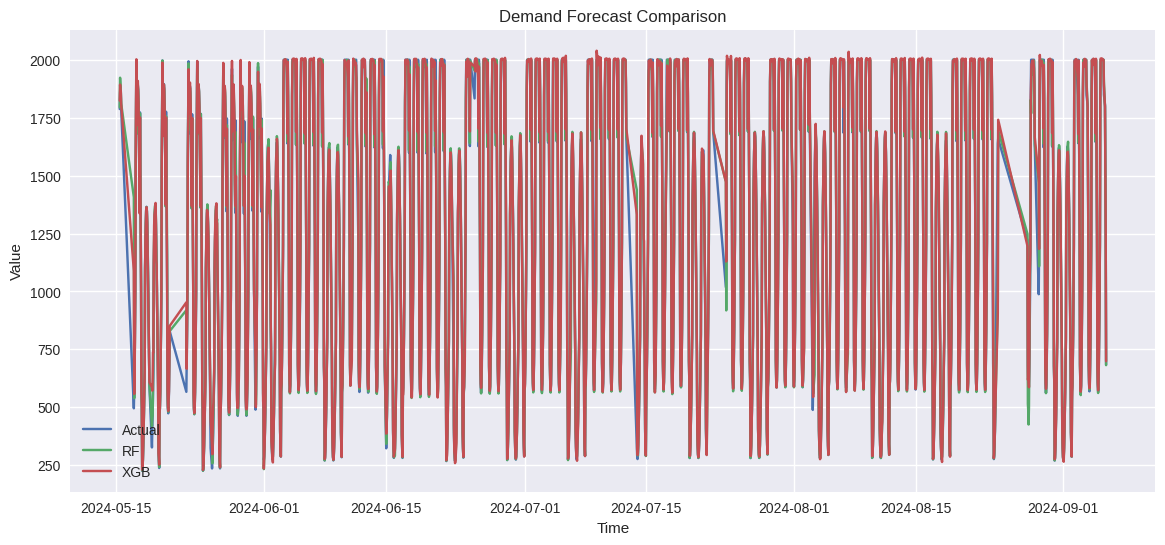

In [14]:
# Compare models
demand_metrics = pd.DataFrame({
    'Random Forest': rf_demand_metrics,
    'XGBoost': xgb_demand_metrics
}).T
print("Demand Metrics Comparison:")
print(demand_metrics)

# Plot comparison
plot_comparison(y_val_demand, [rf_demand_pred, xgb_demand_pred], val_df.index, 
                'Demand Forecast Comparison', 'demand_comparison.png', ['RF', 'XGB'])

### 8. Solar Generation Forecasting

Description

We train and evaluate Random Forest and XGBoost for solar_power forecasting.

-   **Feature Selection**

In [15]:
# Define features for solar
solar_features = [
    'hour', 'day_of_week', 'month', 'weather_temperature', 'weather_humidity', 'weather_wind_speed',
    'solar_power_roll_mean', 'solar_power_roll_std'
] + [f'solar_power_lag{i}' for i in range(1, 25)]

# Prepare training and validation data
X_train_solar = train_df[solar_features]
y_train_solar = train_df['solar_power']
X_val_solar = val_df[solar_features]
y_val_solar = val_df['solar_power']

1. **Random Forest**

Best Params: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 100}
Random Forest - Solar Generation Forecast Metrics: {'MAE': 26.0082494148819, 'RMSE': 55.33013613538894, 'R2': 0.985146177199053}


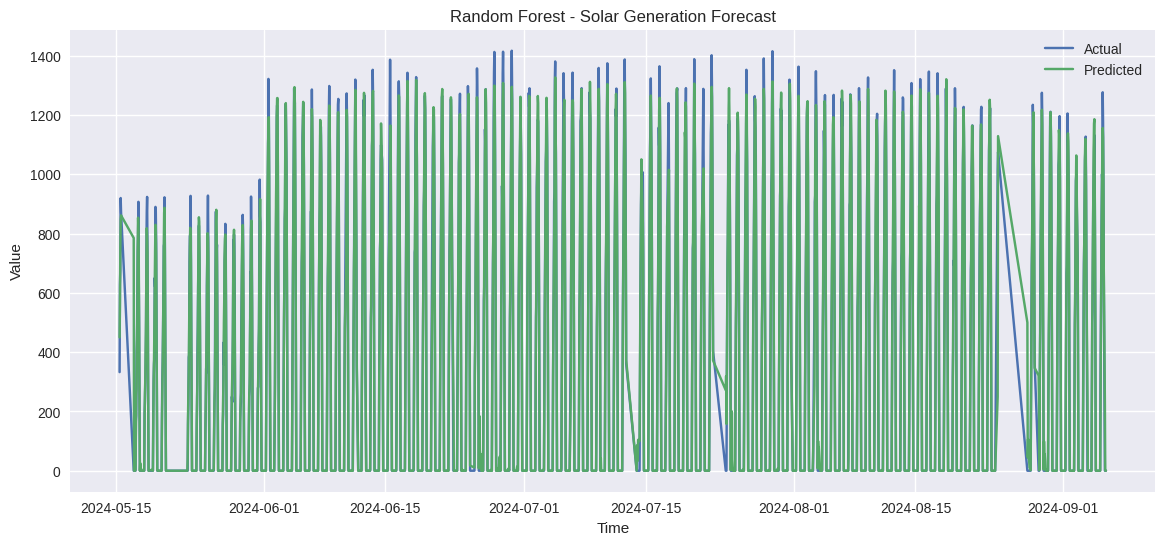

In [16]:
# Train RF
rf_solar = train_model(RandomForestRegressor(random_state=42), rf_param_grid, 
                       X_train_solar, y_train_solar, tscv)

# Evaluate and plot
rf_solar_pred = rf_solar.predict(X_val_solar)
rf_solar_metrics = evaluate_and_plot(y_val_solar, rf_solar_pred, val_df.index, 
                                    'Random Forest - Solar Generation Forecast', 'rf_solar.png')

2. **XGBoost**

Best Params: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100}
XGBoost - Solar Generation Forecast Metrics: {'MAE': 27.4049672927146, 'RMSE': 57.94505214314296, 'R2': 0.9837090099968}


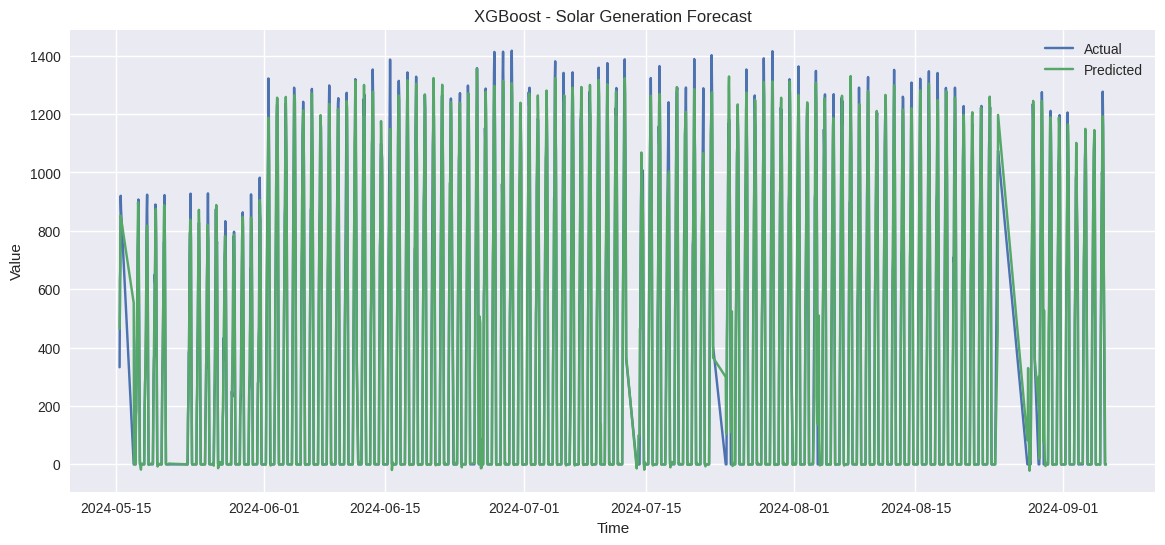

In [17]:
# Train XGB
xgb_solar = train_model(XGBRegressor(random_state=42), xgb_param_grid, 
                        X_train_solar, y_train_solar, tscv)

# Evaluate and plot
xgb_solar_pred = xgb_solar.predict(X_val_solar)
xgb_solar_metrics = evaluate_and_plot(y_val_solar, xgb_solar_pred, val_df.index, 
                                     'XGBoost - Solar Generation Forecast', 'xgb_solar.png')

**Comparision**

Solar Metrics Comparison:
                     MAE       RMSE        R2
Random Forest  26.008249  55.330136  0.985146
XGBoost        27.404967  57.945052  0.983709


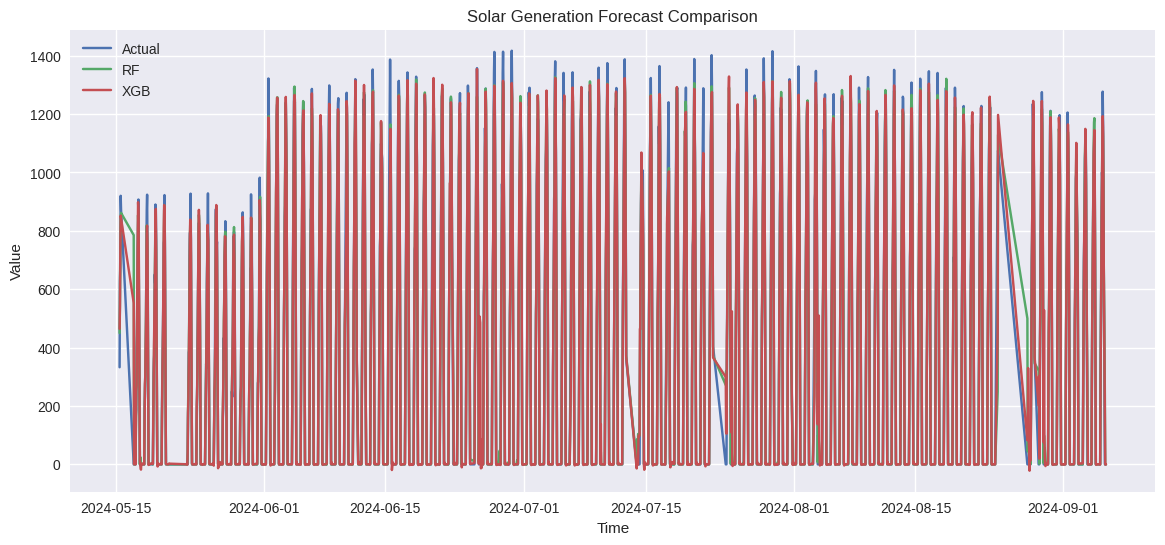

In [18]:
# Compare models
solar_metrics = pd.DataFrame({
    'Random Forest': rf_solar_metrics,
    'XGBoost': xgb_solar_metrics
}).T
print("Solar Metrics Comparison:")
print(solar_metrics)

# Plot comparison
plot_comparison(y_val_solar, [rf_solar_pred, xgb_solar_pred], val_df.index, 
                'Solar Generation Forecast Comparison', 'solar_comparison.png', ['RF', 'XGB'])

### 9. SHAP Analysis

Description

We analyze feature importance for the best-performing models (XGBoost) using SHAP.


- Input: Trained XGBoost model, validation data
- Process: Compute SHAP values, generate summary plots
- Output: Visualizations of feature importance

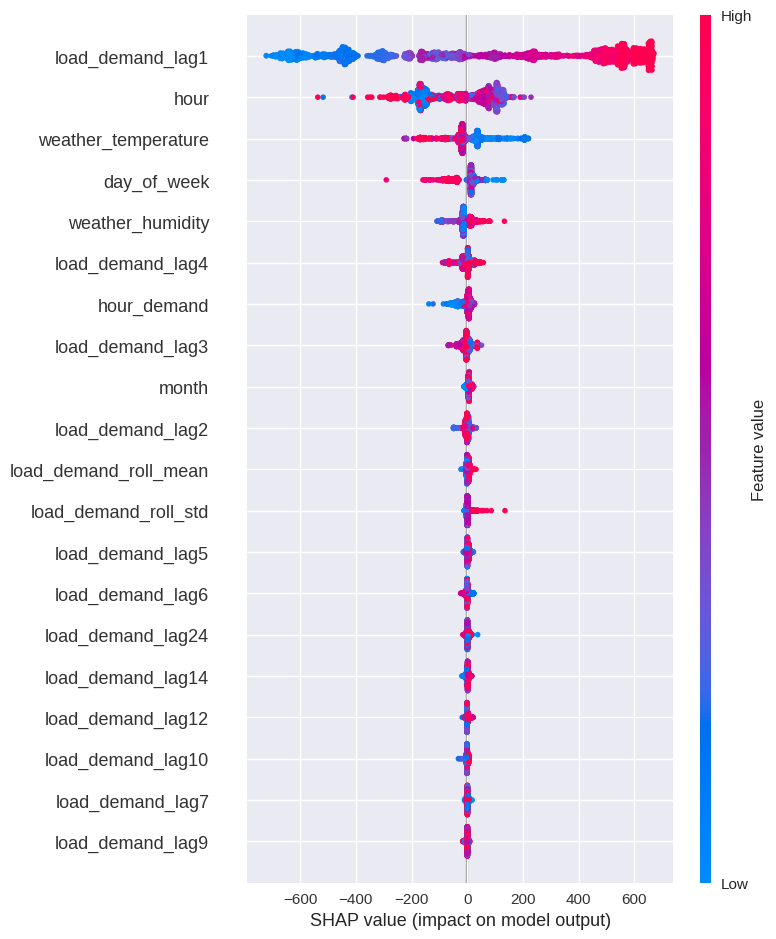

In [19]:
# SHAP for demand
explainer_demand = shap.Explainer(xgb_demand.best_estimator_)
shap_values_demand = explainer_demand(X_val_demand)
shap.summary_plot(shap_values_demand, X_val_demand, show=False)
plt.savefig('shap_demand.png')
plt.show()

# SHAP for solar
#explainer_solar = shap.Explainer(xgb_solar.best_estimator_)
#shap_values_solar = explainer_solar(X_val_solar)
#shap.summary_plot(shap_values_solar, X_val_solar, show=False)
#plt.savefig('shap_solar.png')
#plt.show()

### 10. Final Model Evaluation

Description

We evaluate the best models (XGBoost) on the test set.

- **Demand**

Final Demand Forecast - Test Set Metrics: {'MAE': 17.50987791362815, 'RMSE': 44.096107426363034, 'R2': 0.9942934753088587}


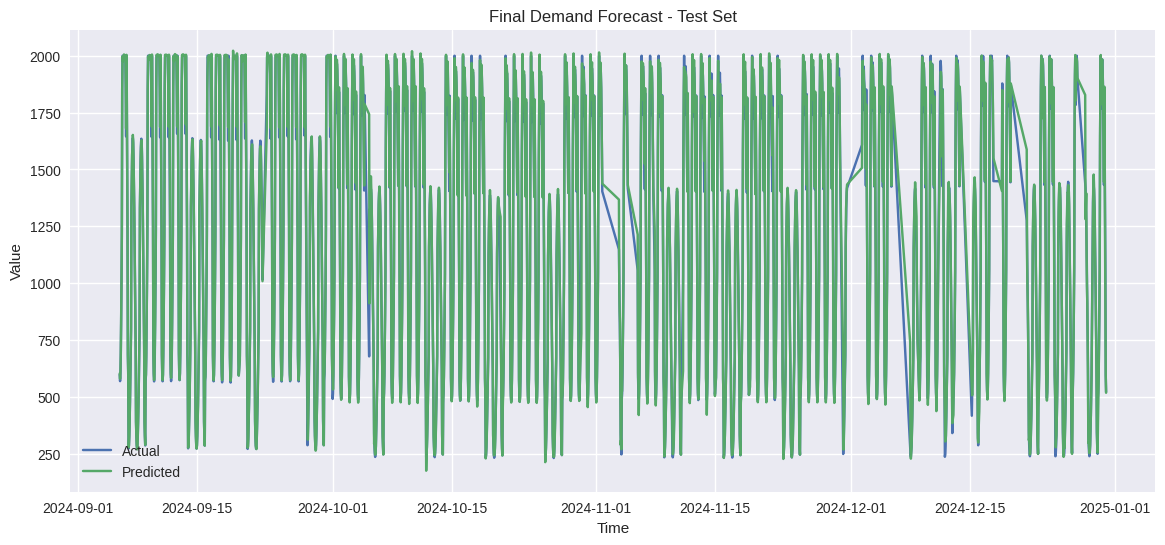

In [20]:
# Evaluate on test set
X_test_demand = test_df[demand_features]
y_test_demand = test_df['load_demand']
final_demand_pred = xgb_demand.predict(X_test_demand)
final_demand_metrics = evaluate_and_plot(y_test_demand, final_demand_pred, test_df.index, 
                                        'Final Demand Forecast - Test Set', 'final_demand.png')

- **Solar Generation**

Final Solar Generation Forecast - Test Set Metrics: {'MAE': 19.177185141777862, 'RMSE': 38.38490647744686, 'R2': 0.9846954300678028}


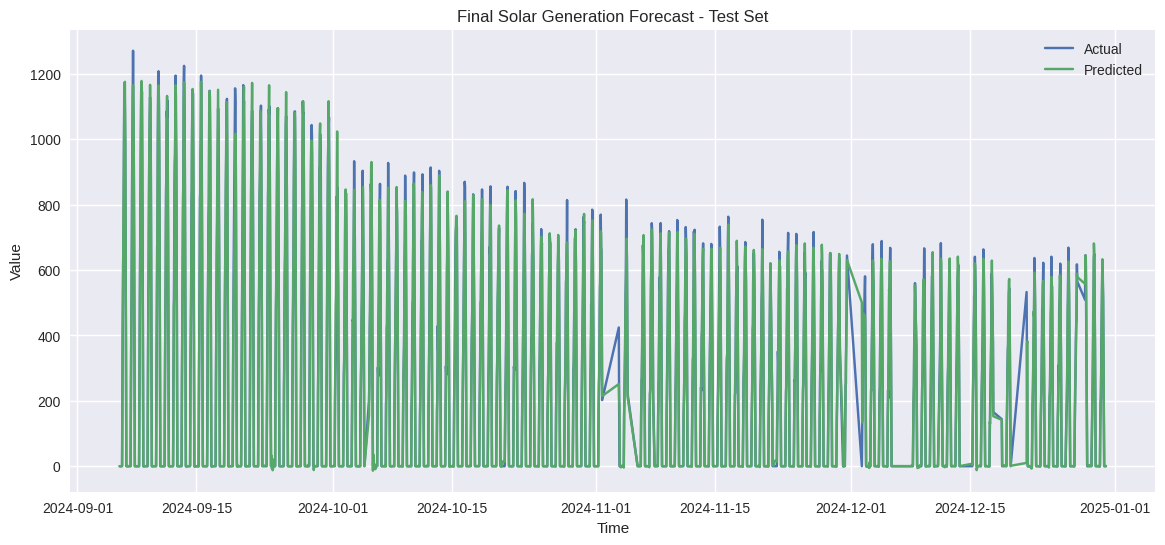

In [21]:
# Evaluate on test set
X_test_solar = test_df[solar_features]
y_test_solar = test_df['solar_power']
final_solar_pred = xgb_solar.predict(X_test_solar)
final_solar_metrics = evaluate_and_plot(y_test_solar, final_solar_pred, test_df.index, 
                                       'Final Solar Generation Forecast - Test Set', 'final_solar.png')

In [22]:

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15842 entries, 2023-01-03 00:00:00 to 2024-12-30 23:00:00
Data columns (total 97 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   weather_hour           15842 non-null  int32  
 1   weather_day_of_year    15842 non-null  int32  
 2   weather_is_weekend     15842 non-null  bool   
 3   hour                   15842 non-null  int32  
 4   day_of_year            15842 non-null  int32  
 5   is_weekend             15842 non-null  bool   
 6   hour_sin               15842 non-null  float64
 7   hour_cos               15842 non-null  float64
 8   day_sin                15842 non-null  float64
 9   day_cos                15842 non-null  float64
 10  weather_season         15842 non-null  object 
 11  season                 15842 non-null  object 
 12  weather_temperature    15842 non-null  float64
 13  weather_cloud_cover    15842 non-null  float64
 14  weather_humidity   

### 11. Future Forecasting

Description

We forecast the next 7 days (168 hours) using XGBoost models.

In [23]:
def rolling_forecast(model, features, data, steps):
    """
    Perform rolling forecast for future steps.
    
    Parameters:
    - model: Trained model (e.g., XGBoost)
    - features: List of feature names
    - data: DataFrame with initial features (at least one row)
    - steps: Number of forecast steps
    
    Returns:
    - List of forecasted values
    """
    forecasts = []
    current_data = data.copy()
    
    # Extract target from a lag feature (e.g., 'load_demand' from 'load_demand_lag1')
    target = None
    for feature in features:
        if '_lag' in feature:
            target = feature.split('_lag')[0]
            break
    if target is None:
        raise ValueError("No lag feature found in features list. Check feature definitions.")
    
    for step in range(steps):
        # Ensure data has at least one row
        if current_data.empty:
            raise ValueError("Current data is empty. Check feature initialization.")
        
        # Extract features for prediction
        X_future = current_data[features].iloc[0].values.reshape(1, -1)
        pred = model.predict(X_future)[0]
        forecasts.append(pred)
        
        # Create new row for next step
        new_time = current_data.index[0] + pd.Timedelta(hours=1)
        new_row = pd.DataFrame(index=[new_time], columns=current_data.columns)
        
        # Update time-based features
        new_row['hour'] = new_time.hour
        new_row['day_of_week'] = new_time.dayofweek
        new_row['month'] = new_time.month
        
        # Update lag features
        for lag in range(24, 1, -1):
            new_row[f'{target}_lag{lag}'] = current_data[f'{target}_lag{lag-1}'].iloc[0]
        new_row[f'{target}_lag1'] = pred
        
        # Update rolling features (approximate with latest values)
        new_row[f'{target}_roll_mean'] = current_data[f'{target}_roll_mean'].iloc[0]
        new_row[f'{target}_roll_std'] = current_data[f'{target}_roll_std'].iloc[0]
        
        # Update interaction feature for demand
        if target == 'load_demand':
            new_row['hour_demand'] = new_row['hour'] * pred
        
        # Copy weather features
        new_row['weather_temperature'] = current_data['weather_temperature'].iloc[0]
        new_row['weather_humidity'] = current_data['weather_humidity'].iloc[0]
        new_row['weather_wind_speed'] = current_data['weather_wind_speed'].iloc[0]
        
        # Update current_data for next iteration
        current_data = pd.concat([current_data, new_row])
        current_data = current_data.tail(24)
    
    return forecasts

# Forecast demand
#future_demand = rolling_forecast(xgb_demand.best_estimator_, demand_features, future_df.iloc[[0]], future_steps)

# Forecast solar
#future_solar = rolling_forecast(xgb_solar.best_estimator_, solar_features, future_df.iloc[[0]], future_steps)

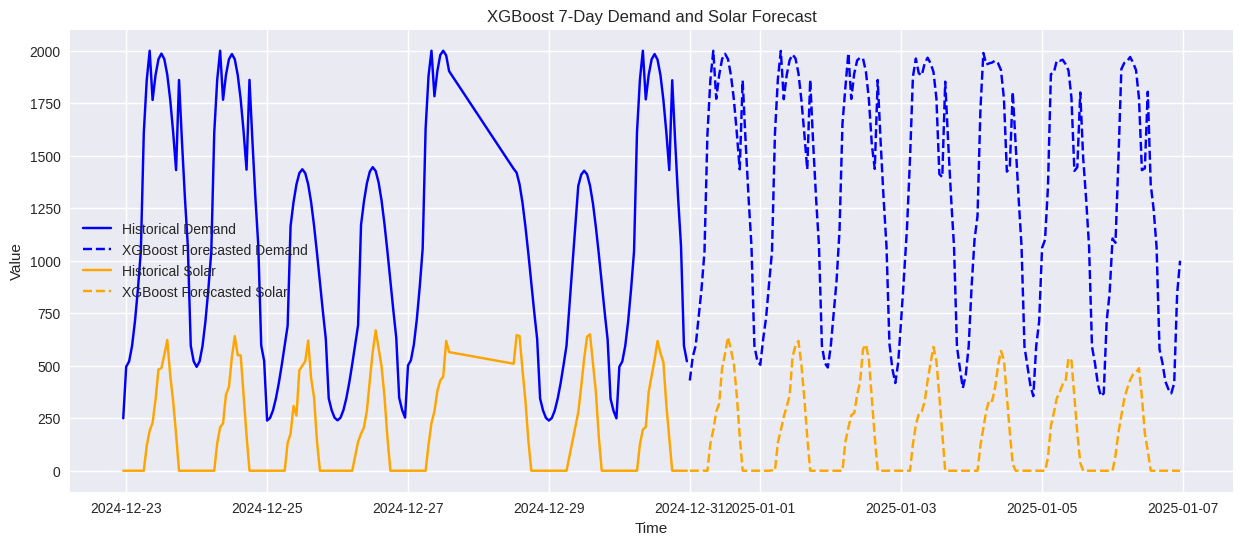

In [24]:
# Define forecast horizon (7 days = 168 hours)
future_steps = 168

# Calculate average weather features for each hour from the last 30 days
last_30_days = df.iloc[-30*24:]
weather_avg_by_hour = last_30_days.groupby(last_30_days.index.hour)[
    ['weather_temperature', 'weather_humidity', 'weather_wind_speed']
].mean()

# Initialize future_df with the last 24 hours of historical data
last_24_rows = df.tail(24).copy()
future_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(hours=1), periods=future_steps, freq='H')
future_df = pd.DataFrame(index=future_dates)

# Extend last_24_rows with future dates for forecasting
future_df_full = pd.concat([last_24_rows, future_df])

# Add time-based features for the entire DataFrame
future_df_full['hour'] = future_df_full.index.hour
future_df_full['day_of_week'] = future_df_full.index.dayofweek
future_df_full['month'] = future_df_full.index.month

# Assign dynamic weather features with variability
np.random.seed(42)  # For reproducibility
for idx, hour in enumerate(future_df_full['hour']):
    if idx >= 24:  # Only update future rows
        future_df_full.iloc[idx, future_df_full.columns.get_loc('weather_temperature')] = (
            weather_avg_by_hour.loc[hour, 'weather_temperature'] * (1 + np.random.uniform(-0.1, 0.1))
        )
        future_df_full.iloc[idx, future_df_full.columns.get_loc('weather_humidity')] = (
            weather_avg_by_hour.loc[hour, 'weather_humidity'] * (1 + np.random.uniform(-0.1, 0.1))
        )
        future_df_full.iloc[idx, future_df_full.columns.get_loc('weather_wind_speed')] = (
            weather_avg_by_hour.loc[hour, 'weather_wind_speed'] * (1 + np.random.uniform(-0.1, 0.1))
        )

# Fill initial weather features for historical rows
future_df_full['weather_temperature'].iloc[:24] = last_24_rows['weather_temperature']
future_df_full['weather_humidity'].iloc[:24] = last_24_rows['weather_humidity']
future_df_full['weather_wind_speed'].iloc[:24] = last_24_rows['weather_wind_speed']

# Initialize lag and rolling features for historical rows
for col in last_24_rows.columns:
    if 'lag' in col or 'roll_mean' in col or 'roll_std' in col or 'hour_demand' in col:
        future_df_full[col].iloc[:24] = last_24_rows[col]

# Initialize target columns for historical rows
future_df_full['load_demand'].iloc[:24] = last_24_rows['load_demand']
future_df_full['solar_power'].iloc[:24] = last_24_rows['solar_power']

# Forecast solar first (since demand might depend on solar lags in future iterations)
future_solar = rolling_forecast(rf_solar.best_estimator_, solar_features, future_df_full.iloc[:24], future_steps)

# Update future_df_full with solar forecasts for demand forecasting
for i in range(future_steps):
    for lag in range(1, 25):
        idx = 24 + i - lag
        if idx >= 0:
            future_df_full[f'solar_power_lag{lag}'].iloc[24 + i] = future_solar[idx] if idx < len(future_solar) else future_df_full[f'solar_power_lag{lag}'].iloc[23]

# Forecast demand using updated solar lags
future_demand = rolling_forecast(rf_demand.best_estimator_, demand_features, future_df_full.iloc[:24], future_steps)

# Plot the results
plt.figure(figsize=(15, 6))
plt.plot(df.index[-168:], df['load_demand'][-168:], label='Historical Demand', color='blue')
plt.plot(future_dates, future_demand, label='XGBoost Forecasted Demand', color='blue', linestyle='--')
plt.plot(df.index[-168:], df['solar_power'][-168:], label='Historical Solar', color='orange')
plt.plot(future_dates, future_solar, label='XGBoost Forecasted Solar', color='orange', linestyle='--')
plt.legend()
plt.title('XGBoost 7-Day Demand and Solar Forecast')
plt.xlabel('Time')
plt.ylabel('Value')
plt.savefig('xgboost_future_forecast.png')
plt.show()

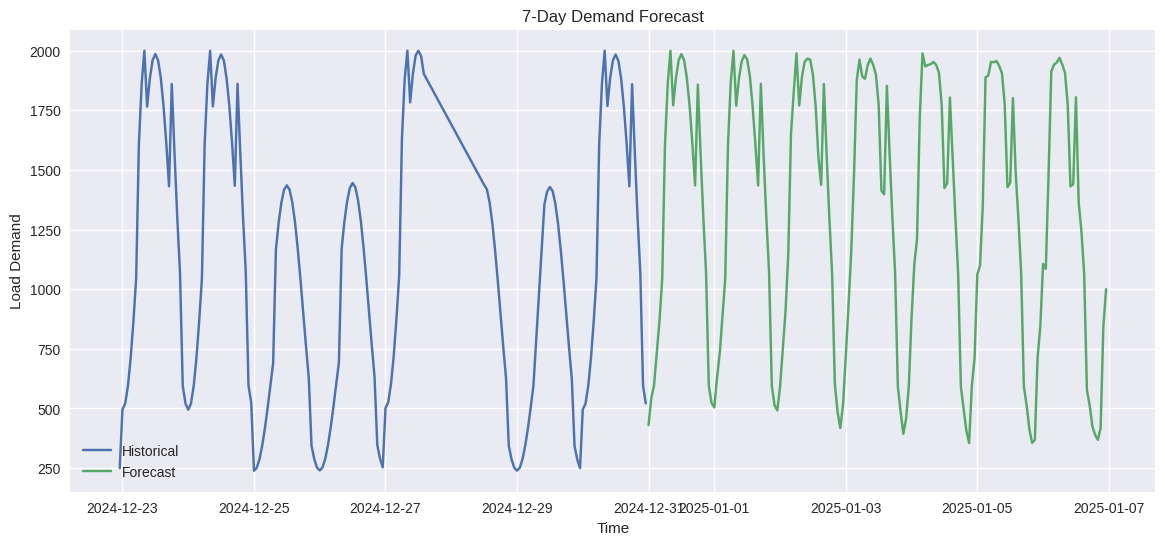

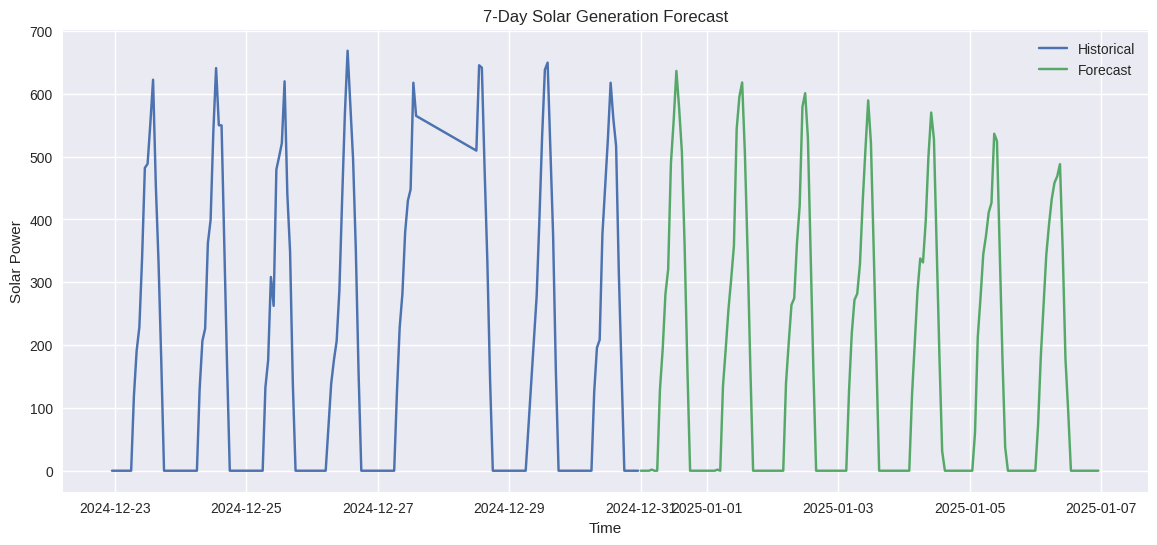

In [25]:
# Plot demand forecast
plt.figure(figsize=(14, 6))
plt.plot(df.index[-168:], df['load_demand'][-168:], label='Historical')
plt.plot(future_dates, future_demand, label='Forecast')
plt.title('7-Day Demand Forecast')
plt.xlabel('Time')
plt.ylabel('Load Demand')
plt.legend()
plt.savefig('future_demand.png')
plt.show()

# Plot solar forecast
plt.figure(figsize=(14, 6))
plt.plot(df.index[-168:], df['solar_power'][-168:], label='Historical')
plt.plot(future_dates, future_solar, label='Forecast')
plt.title('7-Day Solar Generation Forecast')
plt.xlabel('Time')
plt.ylabel('Solar Power')
plt.legend()
plt.savefig('future_solar.png')
plt.show()

In [26]:
!pip install prophet

03:53:37 - cmdstanpy - INFO - Chain [1] start processing
03:53:40 - cmdstanpy - INFO - Chain [1] done processing


Prophet - Demand Forecast on Validation Set Metrics: {'MAE': 183.86018282403435, 'RMSE': 223.6930056460642, 'R2': 0.861483933034049}


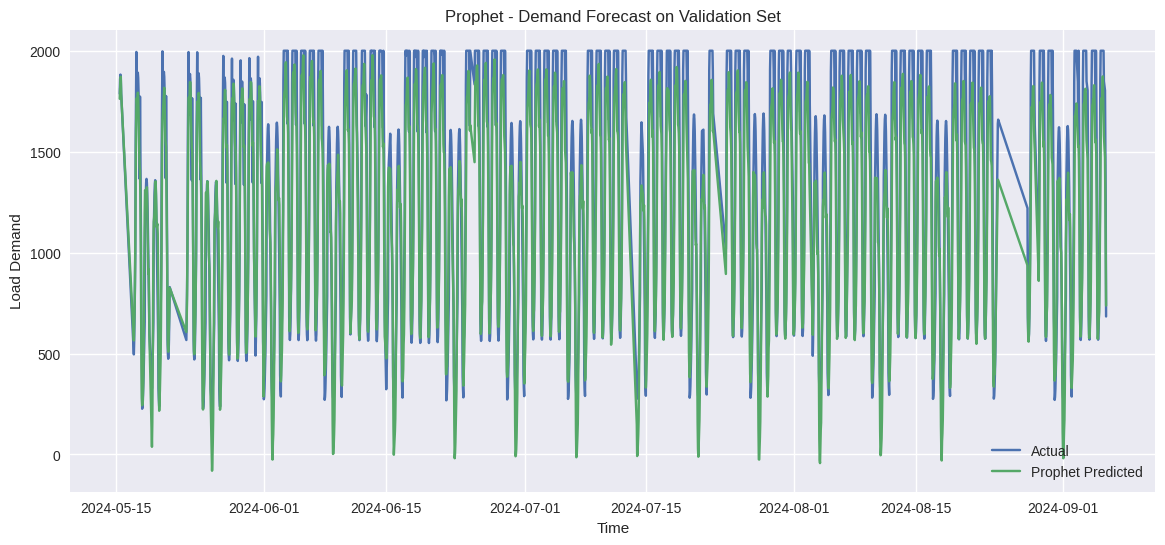

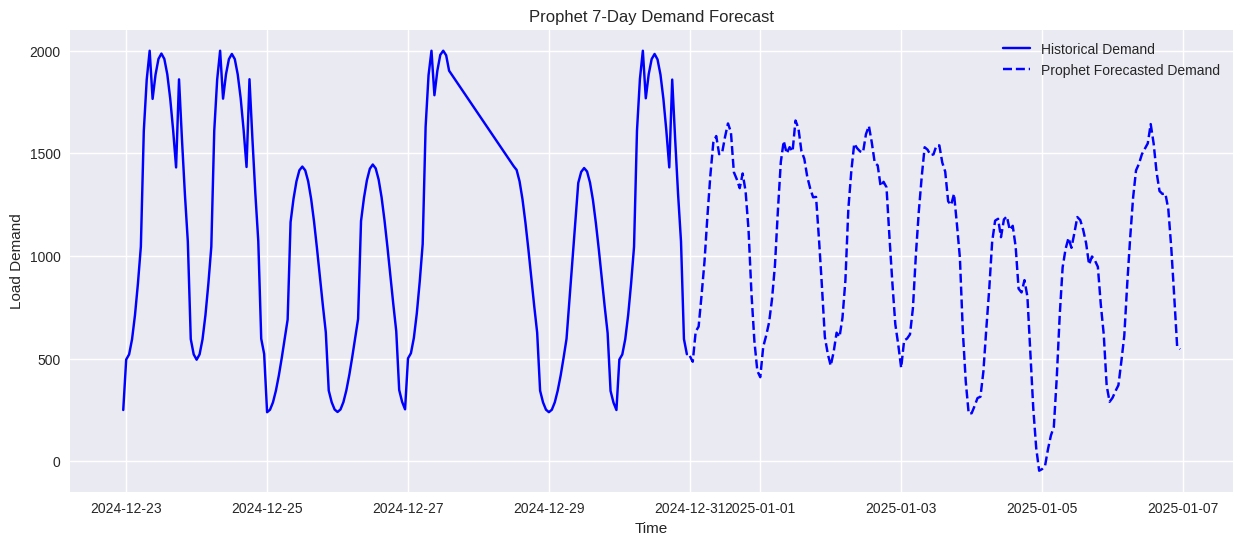

In [27]:
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

prophet_df = df.copy().reset_index()

# Prepare data for Prophet (demand forecasting)
prophet_df = prophet_df.rename(columns={prophet_df.columns[0]: 'ds', 'load_demand': 'y'})
# Add weather regressors
prophet_df['weather_temperature'] = df['weather_temperature'].values
prophet_df['weather_humidity'] = df['weather_humidity'].values
prophet_df['weather_wind_speed'] = df['weather_wind_speed'].values

# Train-validation split aligned with your existing split
prophet_train_df = prophet_df.iloc[:len(train_df)]
prophet_val_df = prophet_df.iloc[len(train_df):len(train_df) + len(val_df)]

# Initialize Prophet with tuned seasonality
model = Prophet(
    yearly_seasonality=False,  # No yearly patterns in 2 years of data
    weekly_seasonality=True,  # Capture day-of-week patterns
    daily_seasonality=True,   # Capture hourly patterns
    seasonality_mode='multiplicative'  # Better for energy data with varying amplitude
)
# Add custom hourly seasonality (24-hour cycle)
model.add_seasonality(name='hourly', period=24, fourier_order=5)
# Add weather regressors
model.add_regressor('weather_temperature')
model.add_regressor('weather_humidity')
model.add_regressor('weather_wind_speed')

# Fit the model
model.fit(prophet_train_df)

# Create future dataframe for validation period + 7-day forecast (168 hours)
future_steps = 168
future_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(hours=1), periods=future_steps, freq='H')
future = pd.DataFrame({'ds': pd.concat([pd.Series(prophet_val_df['ds']), pd.Series(future_dates)], ignore_index=True)})

# Add weather regressors for validation and future periods
# Validation period: use actual weather from val_df
# Future period: use weather_avg_by_hour with noise (same as XGBoost)
future_weather_temp = pd.concat([
    pd.Series(prophet_val_df['weather_temperature'].values),
    pd.Series([weather_avg_by_hour.loc[hour, 'weather_temperature'] * (1 + np.random.uniform(-0.1, 0.1))
               for hour in future['ds'].iloc[len(prophet_val_df):].dt.hour])
], ignore_index=True)

future_weather_humidity = pd.concat([
    pd.Series(prophet_val_df['weather_humidity'].values),
    pd.Series([weather_avg_by_hour.loc[hour, 'weather_humidity'] * (1 + np.random.uniform(-0.1, 0.1))
               for hour in future['ds'].iloc[len(prophet_val_df):].dt.hour])
], ignore_index=True)

future_weather_wind_speed = pd.concat([
    pd.Series(prophet_val_df['weather_wind_speed'].values),
    pd.Series([weather_avg_by_hour.loc[hour, 'weather_wind_speed'] * (1 + np.random.uniform(-0.1, 0.1))
               for hour in future['ds'].iloc[len(prophet_val_df):].dt.hour])
], ignore_index=True)

future['weather_temperature'] = future_weather_temp
future['weather_humidity'] = future_weather_humidity
future['weather_wind_speed'] = future_weather_wind_speed

# Forecast
forecast = model.predict(future)

# Evaluate on validation set
prophet_val_pred = forecast['yhat'].iloc[:len(val_df)]
y_val_demand = val_df['load_demand']
metrics = {
    'MAE': mean_absolute_error(y_val_demand, prophet_val_pred),
    'RMSE': np.sqrt(mean_squared_error(y_val_demand, prophet_val_pred)),
    'R2': r2_score(y_val_demand, prophet_val_pred)
}
print(f"Prophet - Demand Forecast on Validation Set Metrics: {metrics}")

# Plot validation forecast
plt.figure(figsize=(14, 6))
plt.plot(val_df.index, y_val_demand, label='Actual')
plt.plot(val_df.index, prophet_val_pred, label='Prophet Predicted')
plt.title('Prophet - Demand Forecast on Validation Set')
plt.xlabel('Time')
plt.ylabel('Load Demand')
plt.legend()
plt.savefig('prophet_val_demand.png')

# Plot 7-day future forecast with historical context (last 168 hours)
plt.figure(figsize=(15, 6))
plt.plot(df.index[-168:], df['load_demand'][-168:], label='Historical Demand', color='blue')
plt.plot(future_dates, forecast['yhat'].iloc[-future_steps:], label='Prophet Forecasted Demand', color='blue', linestyle='--')
plt.legend()
plt.title('Prophet 7-Day Demand Forecast')
plt.xlabel('Time')
plt.ylabel('Load Demand')
plt.savefig('prophet_future_demand.png')

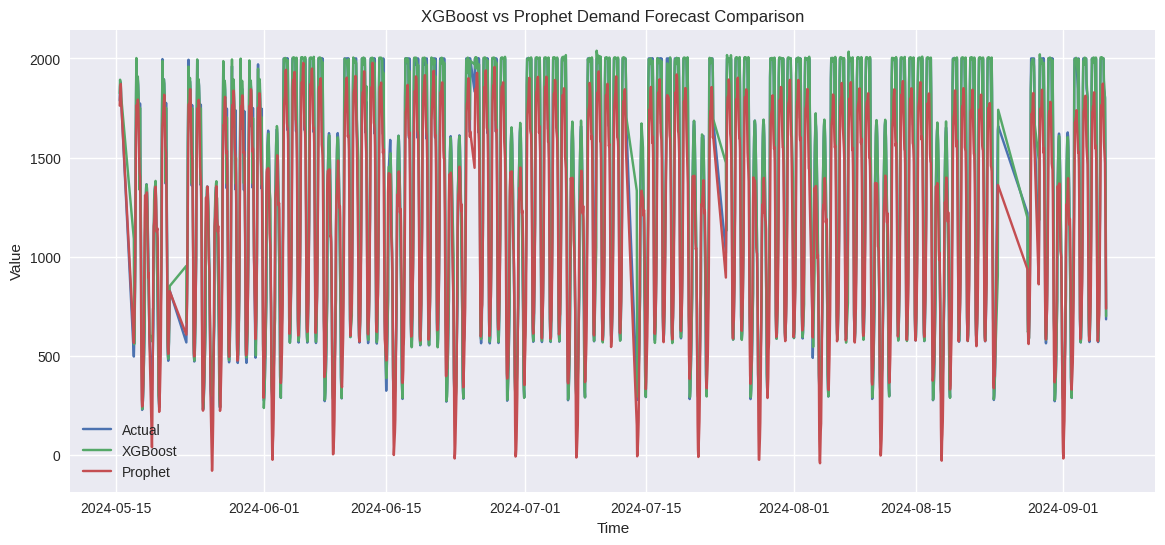

In [28]:
# Plot comparison
plot_comparison(y_val_demand, [xgb_demand_pred, prophet_val_pred], val_df.index, 
                'XGBoost vs Prophet Demand Forecast Comparison', 'final_comparison.png', ['XGBoost', 'Prophet'])

In [29]:
import joblib

# Create directory for models
#os.makedirs('/models', exist_ok=True)

# Save Random Forest model
joblib.dump(rf_solar, 'rf_solar.pkl')
joblib.dump(rf_demand, 'rf_demand.pkl')

# Save XGBoost model
joblib.dump(xgb_demand, 'xgb_demand.pkl')
joblib.dump(xgb_solar, 'xgb_solar.pkl')

# Load the old serialized model
model_1 = joblib.load("/kaggle/working/xgb_solar.pkl")
model_2 = joblib.load("/kaggle/working/xgb_demand.pkl")

# Save it using XGBoost's native format
#model_1.save_model("xgb_solar.json")
#model_2.save_model("xgb_demand.json")

# Access the best XGBoost model inside
xgb_slr = xgb_solar.best_estimator_

# Now save it in native XGBoost format
xgb_slr.get_booster().save_model("xgb_solar.json")

xgb_dmd = xgb_demand.best_estimator_

# Now save it in native XGBoost format
xgb_dmd.get_booster().save_model("xgb_demand.json")

! zip -r model_files.zip /kaggle/working/

  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/xgb_solar.png (deflated 2%)
  adding: kaggle/working/final_demand.png (deflated 2%)
  adding: kaggle/working/rf_demand.png (deflated 2%)
  adding: kaggle/working/xgb_demand.json (deflated 75%)
  adding: kaggle/working/time_series.png (deflated 4%)
  adding: kaggle/working/rf_solar.pkl (deflated 64%)
  adding: kaggle/working/xgb_solar.json (deflated 75%)
  adding: kaggle/working/acf_demand.png (deflated 16%)
  adding: kaggle/working/solar_comparison.png (deflated 2%)
  adding: kaggle/working/final_solar.png (deflated 3%)
  adding: kaggle/working/.virtual_documents/ (stored 0%)
  adding: kaggle/working/prophet_val_demand.png (deflated 2%)
  adding: kaggle/working/xgb_demand.pkl (deflated 70%)
  adding: kaggle/working/future_solar.png (deflated 5%)
  adding: kaggle/working/xgb_solar.pkl (deflated 71%)
  adding: kaggle/working/decomp_solar.png (deflated 4%)
  adding: kaggle/working/demand_comparison.png (deflated 1%)
  adding: 

In [30]:
model_1

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, imp...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [3, 6],
                         'n_estimators': [100, 200]},
             scoring='neg_mean_absolute_error')

In [31]:
from IPython.display import FileLink
FileLink(r'model_files.zip')

/kaggle/working/model_files.zip